# Redes Convolucionais

In [1]:
# Python ≥3.5 é necessário
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 é necessário
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 é necessário
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# imports comuns
import numpy as np
import os

# tornar os resultados reproduzíveis
np.random.seed(42)
tf.random.set_seed(42)

# Visualização de figuras
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# Filtros

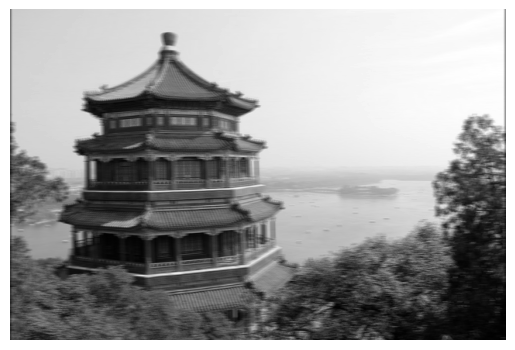

In [3]:
import numpy as np
from sklearn.datasets import load_sample_image

# Carrega imagens
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Cria dois filtros
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # linha vertical
filters[3, :, :, 1] = 1  # linha horizontal

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # mostra a imagem
plt.axis("off")
plt.show()

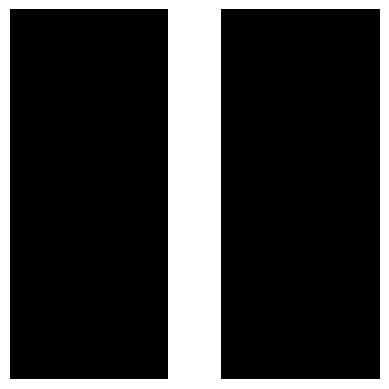

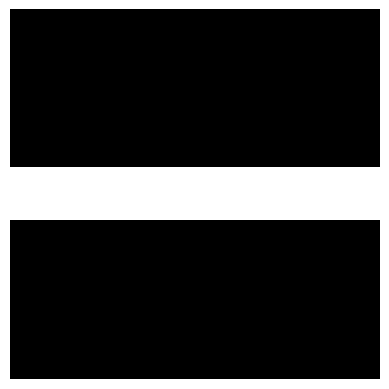

In [4]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

In [5]:
def crop(images):
    return images[150:220, 130:250]

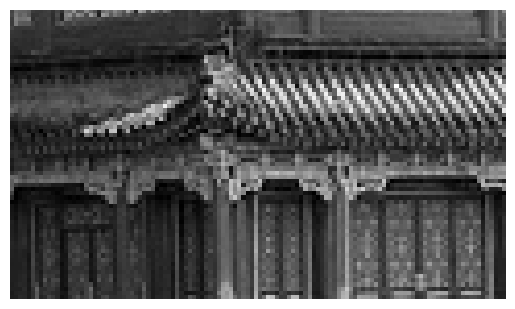

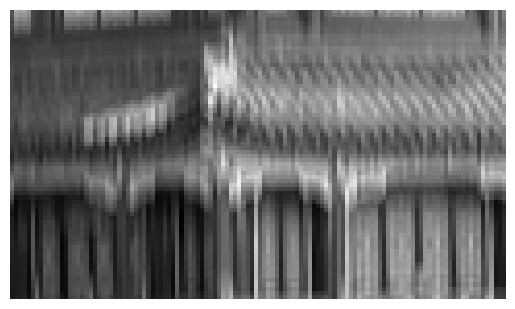

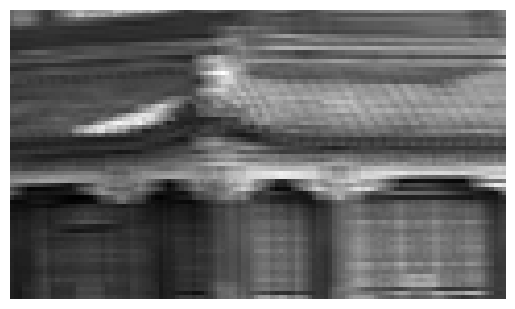

In [6]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

# Camadas poolling

## Max pooling

In [7]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [8]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

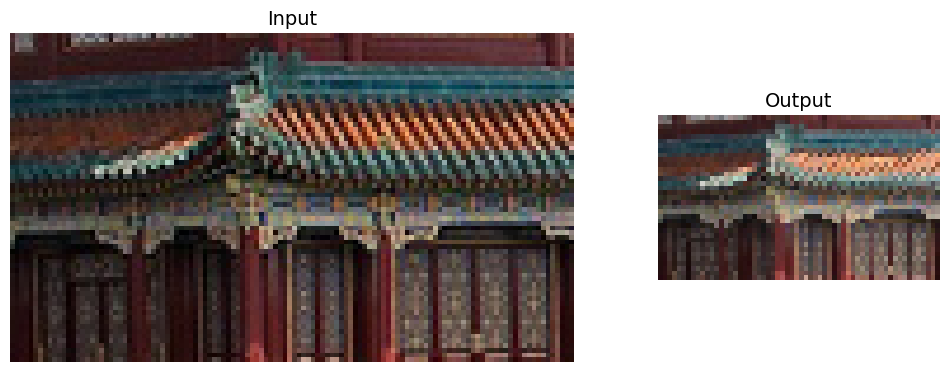

In [9]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  #plota a primeira imagem
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  #saída da primeira imagem
ax2.axis("off")
plt.show()

## Average pooling

In [10]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [11]:
output_avg = avg_pool(cropped_images)

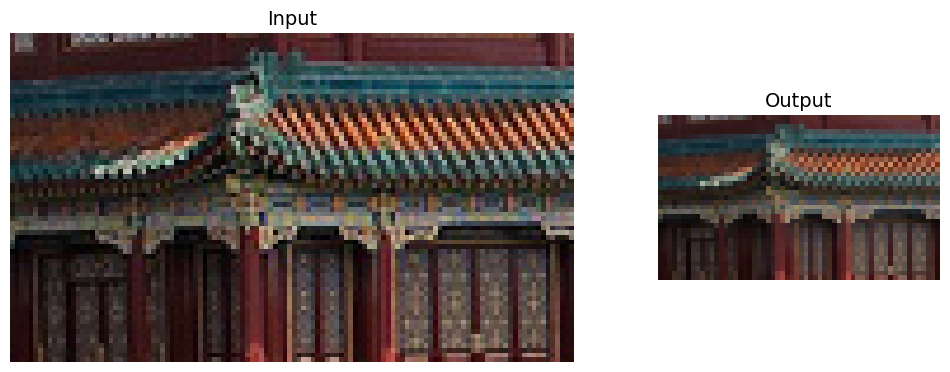

In [12]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plota a primeira imagem
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # saída da primeira imagem
ax2.axis("off")
plt.show()

# _Dataset_ MNIST com uma CNN

In [13]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [14]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] 
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step - accuracy: 0.6418 - loss: 1.0240 - val_accuracy: 0.8594 - val_loss: 0.4441
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 54s 31ms/step - accuracy: 0.8497 - loss: 0.4604 - val_accuracy: 0.8798 - val_loss: 0.3274
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 53s 31ms/step - accuracy: 0.8701 - loss: 0.3816 - val_accuracy: 0.8828 - val_loss: 0.3386
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 53s 31ms/step - accuracy: 0.8867 - loss: 0.3383 - val_accuracy: 0.8918 - val_loss: 0.3099
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 52s 30ms/step - accuracy: 0.8908 - loss: 0.3164 - val_accuracy: 0.8952 - val_loss: 0.3147
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 54s 31ms/step - accuracy: 0.8991 - loss: 0.3019 - val_accuracy: 0.8936 - val_loss: 0.2978
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 55s 32ms/step - accuracy: 0.9033 - loss: 0.2824 - val_accuracy: 0.8852 - val_loss: 0.3203
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 57s 33ms/step - accuracy: 0.9042 -